# TP2 - Détection de présence

*Lucas Valois, Dylan Robins - E2I5*

Dans ce TP nous exploiterons les résultats d'une expérience menée dans un laboratoire en Belgique où les chercheurs voulaient mettre en oeuvre une solution pour prédire les moments où leur bâtiment serait vide. Nous avons donc pour objectif d'entrainer un algorithme à détecter la présence d'une personne dans une pièce à partir de relevés de température, d'humidité, de taux de CO2 et d'intensité lumineuse dans cette même pièce. Pour les besoins de l'expérience, une caméra est également installée dans la pièce afin de confirmer des résultats donnés par l'algorithme.

Dans un premier temps nous allons décrire le jeu de données produit par l'expérience afin d'en dégager les caractéristiques principales. Nous créérons ensuite des modèles prédictifs de trois types différents pour comparer leurs performances et choisir le meilleur. Enfin, nous proposerons un retour critique sur l'expérience menée et le choix des variables observées.

## Partie 1: Analyse univariée des données

Nous commençons par charger le fichier de données "training" qui contient les observations de l'expérience. L'objectif de cette première partie sera d'analyser le jeu de donnée afin de comprendre ce qu'on manipule.

In [21]:
# Load all the libraries we use
from __future__ import annotations

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.metrics import confusion_matrix, roc_curve, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier

sns.set()

In [22]:
def load_df(
    path: str, reduce: bool = False, remove_timestamps: bool = False,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Loads a dataset from an excel file into a Pandas Dataframe"""

    df = pd.read_excel(path, index_col=0)
    print(f"path shape: {df.shape[0]} rows, {df.shape[1]} cols")

    if df.isnull().values.any():
        print("Missing cell values found!")

    # Normalize numeric values
    if reduce:
        numeric_data = df[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]]
        numeric_data = (numeric_data - numeric_data.mean()) / numeric_data.std()
        df[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]] = numeric_data

    # Remove data/time columns
    if remove_timestamps:
        df.drop(["Time", "Date"], axis=1, inplace=True)

    # Split dataset into data/targets/target_names
    targets = df.Occupancy
    target_names = df.Occupancy.unique()
    data = df.drop(["Occupancy"], axis=1)

    return data, targets, target_names

# Load the three datasets
training_data, training_targets, training_targets_names = load_df("datasets/datatraining.xlsx")
test_data, test_targets, test_targets_names = load_df("datasets/datatest.xlsx")
test2_data, test2_targets, test2_targets_names = load_df("datasets/datatest2.xlsx")

# Describe the training data
print("Columns of training_data:", training_data.columns.values)
display(training_data.describe())


path shape: 8143 rows, 8 cols
path shape: 2665 rows, 8 cols
path shape: 9752 rows, 8 cols
Columns of training_data: ['Date' 'Time' 'Temperature' 'Humidity' 'Light' 'CO2' 'HumidityRatio']


,Temperature,Humidity,Light,CO2,HumidityRatio
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863
std,1.016916,5.531211,194.755805,314.320877,0.000852
min,19.000000,16.745000,0.000000,412.750000,0.002674
25%,19.700000,20.200000,0.000000,439.000000,0.003078
50%,20.390000,26.222500,0.000000,453.500000,0.003801
75%,21.390000,30.533333,256.375000,638.833333,0.004352
max,23.180000,39.117500,1546.333333,2028.500000,0.006476


Le jeu de données contient trois types d'information:
- Des mesures à intervalles de temps réguliers de température, de taux d'humidité, de luminosité et de niveau de CO2 réalisée sur 4 capteurs présents dans la pièce.
- La date et l'heure de prise des mesures.
- La présence ou non d'une personne dans la pièce.

Les mesures présentes dans le tableau semblent cohérentes enterme d'unité et d'ordre de grandeur, avec la réalité terrain d'une pièce de laboratoire normalement éclairée et aérée.

Nous traçons ensuite une représentaton temporelle des données afin de visualiser l'évolution de chaque variable au cours de la journée, pour chaque jour de mesure. On représentera chaque variable sur un graphique indépendant, où on tracera des données de chaque jour d'une couleur différente:

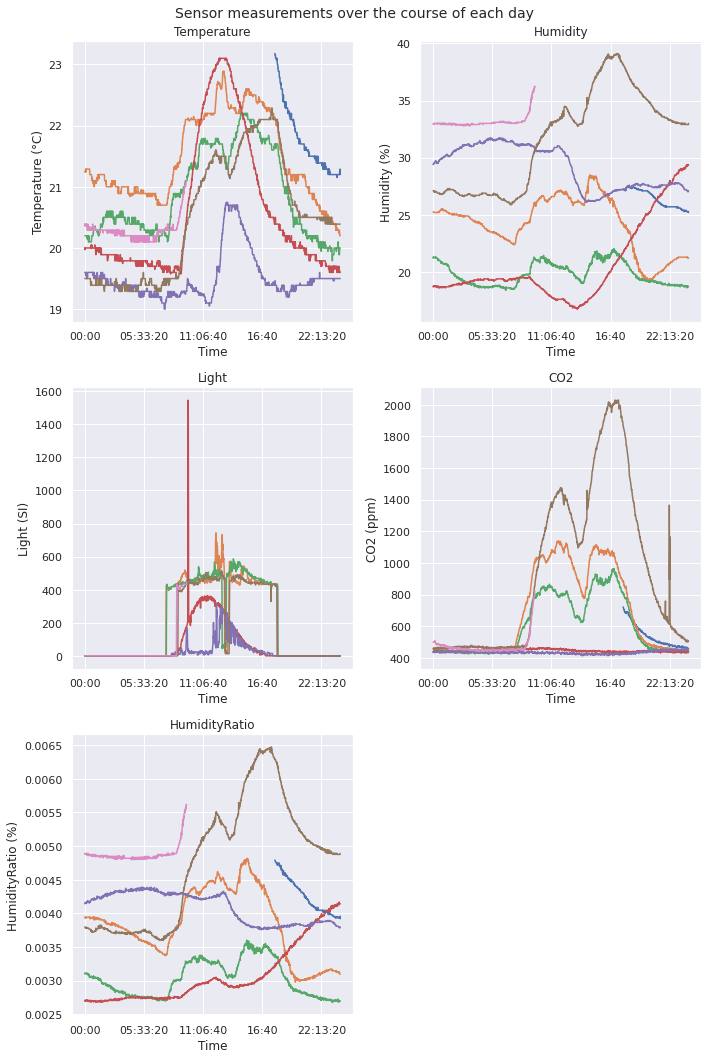

In [23]:
# Plot each

plt.rcParams["figure.figsize"] = [10, 15]
fig, axs = plt.subplots(3, 2)

for day in training_data["Date"].unique():
    day_data = training_data[training_data["Date"] == day].set_index("Time")

    for i, col in enumerate(training_data.columns[2:]):
        day_data[col].plot(ax=axs[i // 2, i % 2])

units = {
    "Temperature": "°C",
    "Humidity": "%",
    "Light": "SI",
    "CO2": "ppm",
    "HumidityRatio": "%"
}
for i, col in enumerate(training_data.columns[2:]):
    axs[i // 2, i % 2].set_title(col)
    axs[i // 2, i % 2].set_ylabel(f"{col} ({units[col]})")
fig.suptitle("Sensor measurements over the course of each day", fontsize=14)
axs[2, 1].axis('off')


plt.tight_layout()


A première vue, les facteur les plus déterminants semblent être le taux de CO2 ainsi que la luminosité dans la pièce. Cela paraît assez logique étant donné qu'une personne risque fort d'allumer la lumière en entrant dans une pièce sombre, et d'émettre du CO2 dans l'air ambiant en respirant.

## Partie 2: Analyse bivariée

Afin de nous assurer de la pertinance de ces variables, nous allons réaliser une analyse bivariée permettant de dégager les corrélations entre les différentes variables et la présence d'une personne dans la pièce.

On veut maintenant charger les données centrées réduites sans les colonnes inutiles à la classification:

In [24]:
training_data, training_targets, training_targets_names = load_df(
    "datasets/datatraining.xlsx", reduce=True, remove_timestamps=True,
)
test_data, test_targets, test_targets_names = load_df(
    "datasets/datatest.xlsx", reduce=True, remove_timestamps=True,
)
test2_data, test2_targets, test2_targets_names = load_df(
    "datasets/datatest2.xlsx", reduce=True, remove_timestamps=True,
)

path shape: 8143 rows, 8 cols
path shape: 2665 rows, 8 cols
path shape: 9752 rows, 8 cols


On peut alors tracer la matrice des corrélations croisées (et le heatmap qui sera plus lisible)

array([[<AxesSubplot:xlabel='Temperature', ylabel='Temperature'>,
        <AxesSubplot:xlabel='Humidity', ylabel='Temperature'>,
        <AxesSubplot:xlabel='Light', ylabel='Temperature'>,
        <AxesSubplot:xlabel='CO2', ylabel='Temperature'>,
        <AxesSubplot:xlabel='HumidityRatio', ylabel='Temperature'>],
       [<AxesSubplot:xlabel='Temperature', ylabel='Humidity'>,
        <AxesSubplot:xlabel='Humidity', ylabel='Humidity'>,
        <AxesSubplot:xlabel='Light', ylabel='Humidity'>,
        <AxesSubplot:xlabel='CO2', ylabel='Humidity'>,
        <AxesSubplot:xlabel='HumidityRatio', ylabel='Humidity'>],
       [<AxesSubplot:xlabel='Temperature', ylabel='Light'>,
        <AxesSubplot:xlabel='Humidity', ylabel='Light'>,
        <AxesSubplot:xlabel='Light', ylabel='Light'>,
        <AxesSubplot:xlabel='CO2', ylabel='Light'>,
        <AxesSubplot:xlabel='HumidityRatio', ylabel='Light'>],
       [<AxesSubplot:xlabel='Temperature', ylabel='CO2'>,
        <AxesSubplot:xlabel='Humidity',

<AxesSubplot:>

<Figure size 720x720 with 0 Axes>

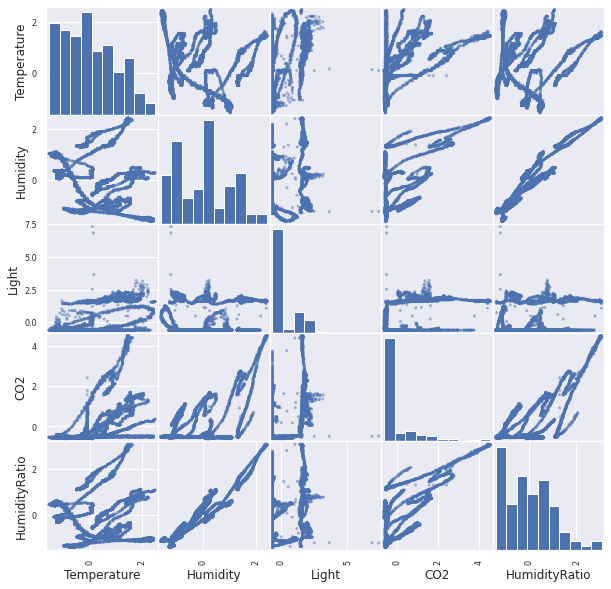

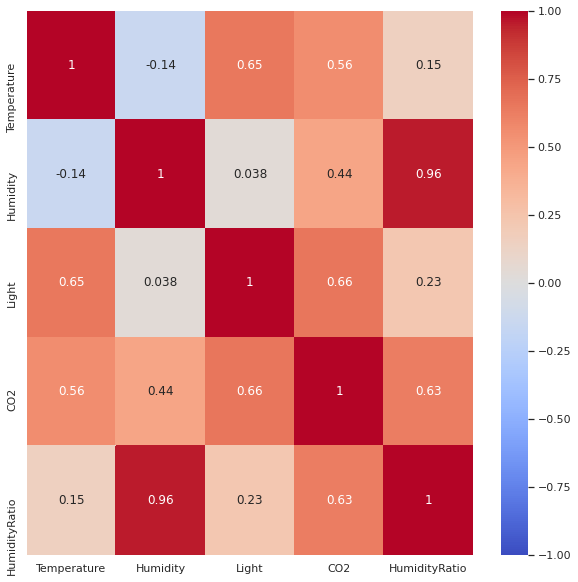

In [25]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.figure(figsize =(10, 10))
display(pd.plotting.scatter_matrix(training_data))

plt.figure(figsize =(10, 10))
display(sns.heatmap(training_data.corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True))

La heat map que nous avons tracé nous permet de mettre en évidence les corrélations principales que nous avions identifées plus haut, à savoir la luminosité, le taux de CO2 dans la pièce mais également la température de la pièce. Ces données sont cohérentes avec l'utilisation classique d'une pièce éclairée et chauffée, cependant si la luminosité semble être une vairable particulièrement pertinente afin de déterminer la présence ou non d'une personne dans la pièce, au vu de sa forte corrélation, il sera intéressant de questionner la validété du modèle de test puisque'il existe un risque considérable qu'un occupant oublira d'éteindre la lumière en sortant.

## Partie 3: LDA

Maintenant que l'on sait quelles variables sont les plus corrélées à la présence d'une personne dans la pièce, on peut créer notre premier modèle prédictif à l'aide d'une analyse discriminante:

In [26]:
# Load data suitable for LDA
training_data, training_targets, training_targets_names = load_df(
    "datasets/datatraining.xlsx", remove_timestamps=True
)
test_data, test_targets, test_targets_names = load_df(
    "datasets/datatest.xlsx", remove_timestamps=True
)
test2_data, test2_targets, test2_targets_names = load_df(
    "datasets/datatest2.xlsx", remove_timestamps=True
)

# Fit data and train model
lda = LinearDiscriminantAnalysis()
lda.fit(training_data, training_targets)


path shape: 8143 rows, 8 cols
path shape: 2665 rows, 8 cols
path shape: 9752 rows, 8 cols


LinearDiscriminantAnalysis()

On peut alors afficher nos données de test dans la base générée par l'analyse discriminante:

Text(0, 0.5, 'Class')

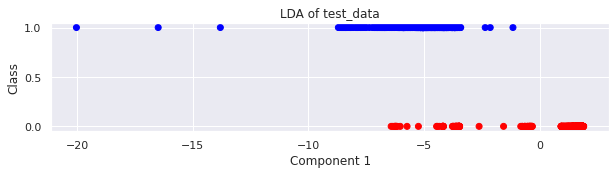

In [27]:
# Transform test data to put it into the new base:
transformed_test_data = lda.transform(test_data)

# Plot the test data
palette = ["red", "blue"]
colours = [palette[i] for i in test_targets]

plt.rcParams["figure.figsize"] = [10, 2]
plt.scatter(transformed_test_data, test_targets, c=colours)
plt.title("LDA of test_data")
plt.xlabel("Component 1")
plt.ylabel("Class")


On voit que les individus de nos deux classes se chevauchent selon l'axe de la composante principale, mais cela ne suffit pas pour exclure cette méthode étant donné qu'il est difficile de juger la distribution des points au sein des groupes. Il serait donc plus avisé, de réaliser un boxplot de ce jeu de données afin d'observer la distribution des deux groupes selon la composante prncipale. Cependant, compte tenu de la taille de notre jeu de données et du temps de calcul associé, nous pouvons réaliser le modèle prédictif en amont et conclure sur sa pertinence au vu de la matrice de confusion.

On applique donc le modèle prédictif généré grâce à la LDA à nos deux jeux de données, et on génère pour chacun la matrice de confusion afin de mesurer la performance du modèle:

Balanced accuracy for 'datatest.xlsx': 0.983242241716679
Balanced accuracy for 'datatest2.xlsx': 0.9052335941161247


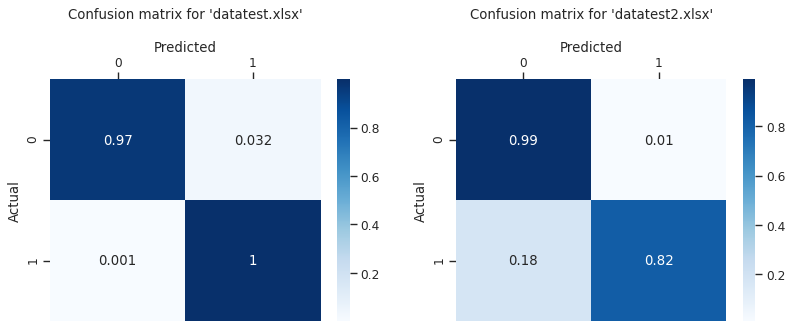

In [28]:
# Apply the predictive model to the 1st dataset
predicted_classes = lda.predict(test_data)

plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

# Plot the confusion matrix for the 1st test dataset
cm_normalized = confusion_matrix(test_targets, predicted_classes, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'", pad=20)
plt.xlabel(f"Predicted")
plt.ylabel(f"Actual")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest.xlsx': {balanced_accuracy_score(test_targets, predicted_classes)}")

# Apply the predictive model to the 2nd dataset
predicted_classes2 = lda.predict(test2_data)

# Plot the confusion matrix for the 2nd test dataset
ax = plt.subplot(1, 2, 2)
cm2_normalized = confusion_matrix(test2_targets, predicted_classes2, normalize="true")
sns.heatmap(cm2_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.xlabel(f"Predicted")
plt.ylabel(f"Actual")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()

print(f"Balanced accuracy for 'datatest2.xlsx': {balanced_accuracy_score(test2_targets, predicted_classes2)}")

On voit que le modèle est très performant sur le premier jeu de données, mais qu'on a un nombre alarmant de faux négatifs avec le deuxième jeu de données. Cela peut s'expliquer de plusieurs façons:
- Le modèle est trop spécifique à la base de données de training
- Les variables choisies ne permettent pas à un modèle LDA d'être performant
- La 2e base de données de test possède une anomalie

Testons d'autres méthodes de classification afin de mettre en défaut cette dernière option.

## Partie 4: Classication binaire et courbes ROC

Une autre solution pourrait être un classifieur binaire. Pour choisir la variable la plus pertinante, on trace leurs courbes ROC:

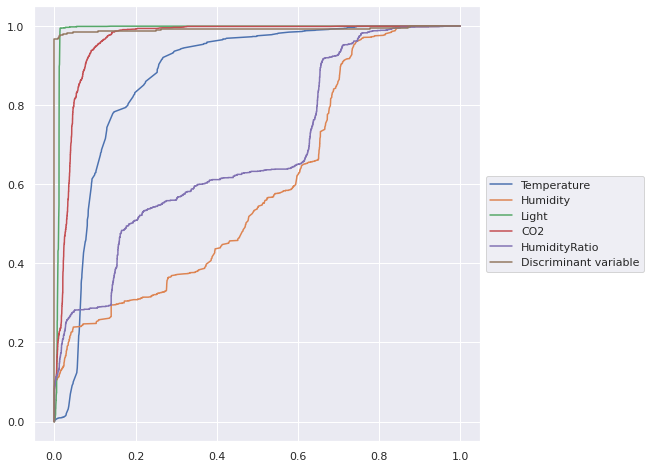

In [29]:
plt.rcParams["figure.figsize"] = [8, 8]

# Plot ROC curves for all variables in dataset
for col in training_data.columns:
    FP, TP, Th = roc_curve(training_targets, training_data[col], pos_label=1)
    plt.plot(FP, TP, label=col)

# Plot ROC curve for main component generated by LDA:
FP, TP, Th = roc_curve(test_targets, transformed_test_data, pos_label=1)
plt.plot(TP, FP, label="Discriminant variable")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

On voit que la variable la plus performante est la lumière. Cependant, on choisira tout de même la composante principale de la LDA étant donné qu'elle permet de prendre les autres variables du jeu de données.

On veut maintenant trouver la valeur optimale du seuil afin de réaliser le classifieur:

In [30]:
def find_optimal_threshold(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate"""

    # calculate roc curve
    probas_false_pos, probas_true_pos, threshold = roc_curve(target, predicted)
    
    # optimal point is closest to top left corner of the 1x1 graph:
    top_left = (0, 1)
    point_coords = [
        (p_true_pos, p_false_pos)
        for p_false_pos, p_true_pos in zip(probas_false_pos, probas_true_pos)
    ]

    # calculate euclidian distances between each point and the top left corner
    distances = []
    for i, point in enumerate(point_coords):
        distances.append((
            i,
            math.sqrt((top_left[0] - point[0]) ** 2 + (top_left[1] - point[1]) ** 2),
        ))

    # find the closest one and return it
    optimal_point = min(distances, key=lambda x: x[1])
    return threshold[optimal_point[0]]


threshold = find_optimal_threshold(test_targets, transformed_test_data)
print(f"Optimal threshold: {threshold}")

Optimal threshold: -3.5173996247128616


Maintenant que l'on a la valeur optimale du seuil, on peut mettre en oeuvre le classifieur binaire:

Balanced accuracy for 'datatest.xlsx': 0.983242241716679
Balanced accuracy for 'datatest2.xlsx': 0.9052335941161247


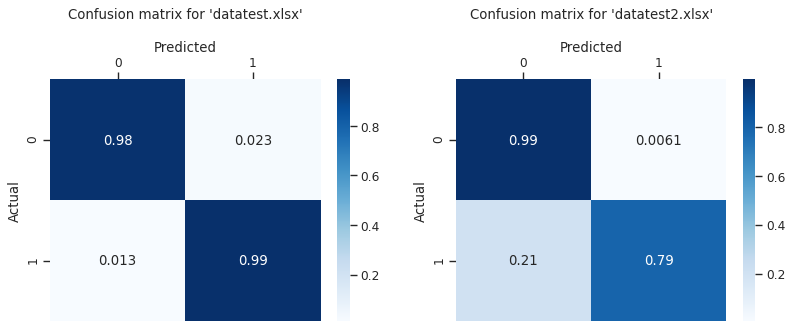

In [31]:
# Transform test data to put it into the new base:
transformed_test_data = lda.transform(test_data)

# Transform test2 data to put it into the new base:
transformed_test2_data = lda.transform(test2_data)

# Apply prediction to the dataframe applying threshold
transformed_test_data_mapped = (transformed_test_data < threshold).astype(int)
transformed_test2_data_mapped = (transformed_test2_data < threshold).astype(int)

plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

# Plot the confusion matrix for the 1st test dataset
cm_normalized = confusion_matrix(test_targets, transformed_test_data_mapped, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'", pad=20)
plt.xlabel(f"Predicted")
plt.ylabel(f"Actual")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest.xlsx': {balanced_accuracy_score(test_targets, predicted_classes)}")

# Apply the predictive model to the 2nd dataset
predicted_classes2 = lda.predict(test2_data)

# Plot the confusion matrix for the 2nd test dataset
ax = plt.subplot(1, 2, 2)
cm2_normalized = confusion_matrix(test2_targets, transformed_test2_data_mapped, normalize="true")
sns.heatmap(cm2_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.xlabel(f"Predicted")
plt.ylabel(f"Actual")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest2.xlsx': {balanced_accuracy_score(test2_targets, predicted_classes2)}")

On voit que nous n'obtenons pas de meilleur résultats qu'avec la simple LDA: le modèle est précis sur la 1e base de test mais nous avons toujours 20% de faux négatifs sur la deuxième.

## Partie 5: K plus proches voisins

Une autre méthode que l'on peut essayer est la méthode des K plus proches voisins. En se basant sur l'exemple fourni sur le site de scikit-learn nous pouvons facilement mettre en place un modèle prédictif:

Balanced accuracy for 'datatest.xlsx': 0.9208663608807994
Balanced accuracy for 'datatest2.xlsx': 0.8883437698909538


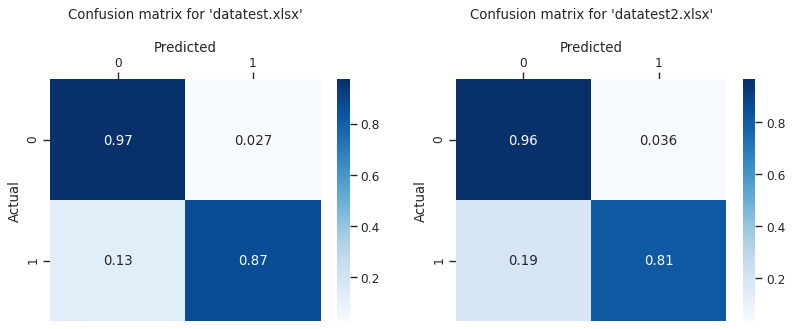

In [32]:
k = 3
model = KNeighborsClassifier(n_neighbors=k)
model.fit(training_data, training_targets)


plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

test_data_predicted = model.predict(test_data)

cm_normalized = confusion_matrix(test_targets, test_data_predicted, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
test_data_predicted = model.predict(test_data)
print(f"Balanced accuracy for 'datatest.xlsx': {balanced_accuracy_score(test_targets, test_data_predicted)}")

ax = plt.subplot(1, 2, 2)

test2_data_predicted = model.predict(test2_data)

cm_normalized = confusion_matrix(test2_targets, test2_data_predicted, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest2.xlsx': {balanced_accuracy_score(test2_targets, test2_data_predicted)}")


On voit que l'on a toujours le même problème: le modèle fonctionne bien sur la 1e base mais qu'il reste près de 20% de faux négatifs sur la deuxième.

## Partie 6: QDA

Enfin, on essaye un modèle basé sur une analyse discriminante quadratique pour espérer trouver un classifieur qui fonctionne sur nos deux bases de test:

Balanced accuracy for 'datatest.xlsx': 0.9809655589828852
Balanced accuracy for 'datatest.xlsx': 0.9040399183028252


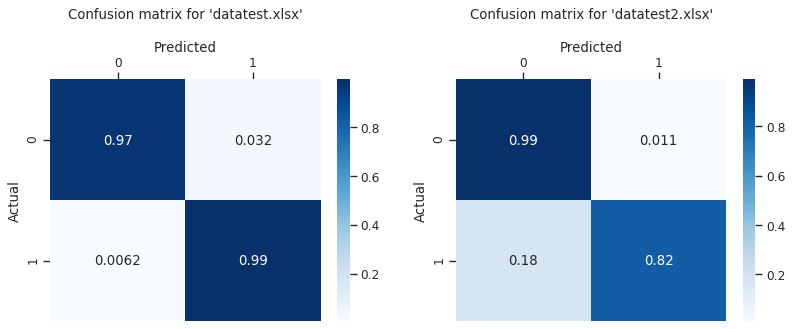

In [33]:
# Fit data and train model
qda = QuadraticDiscriminantAnalysis()
qda.fit(training_data, training_targets)
predicted_classes = qda.predict(test_data)

plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

cm_normalized = confusion_matrix(test_targets, predicted_classes, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest.xlsx': {balanced_accuracy_score(test_targets, predicted_classes)}")

predicted_classes2 = qda.predict(test2_data)

ax = plt.subplot(1, 2, 2)
cm2_normalized = confusion_matrix(test2_targets, predicted_classes2, normalize="true")
sns.heatmap(cm2_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest.xlsx': {balanced_accuracy_score(test2_targets, predicted_classes2)}")


Malheureusement ce classifieur n'est pas plus performant que les autres sur cette base de test problématique.

## Partie 7: les 20% de faux négatifs

Afin de mieux comprendre l'origine de nos peines avec le 2e jeu de test, nous voulons les mettre en évidence sur la représentation en temporel créée dans la partie 1.

path shape: 9752 rows, 8 cols


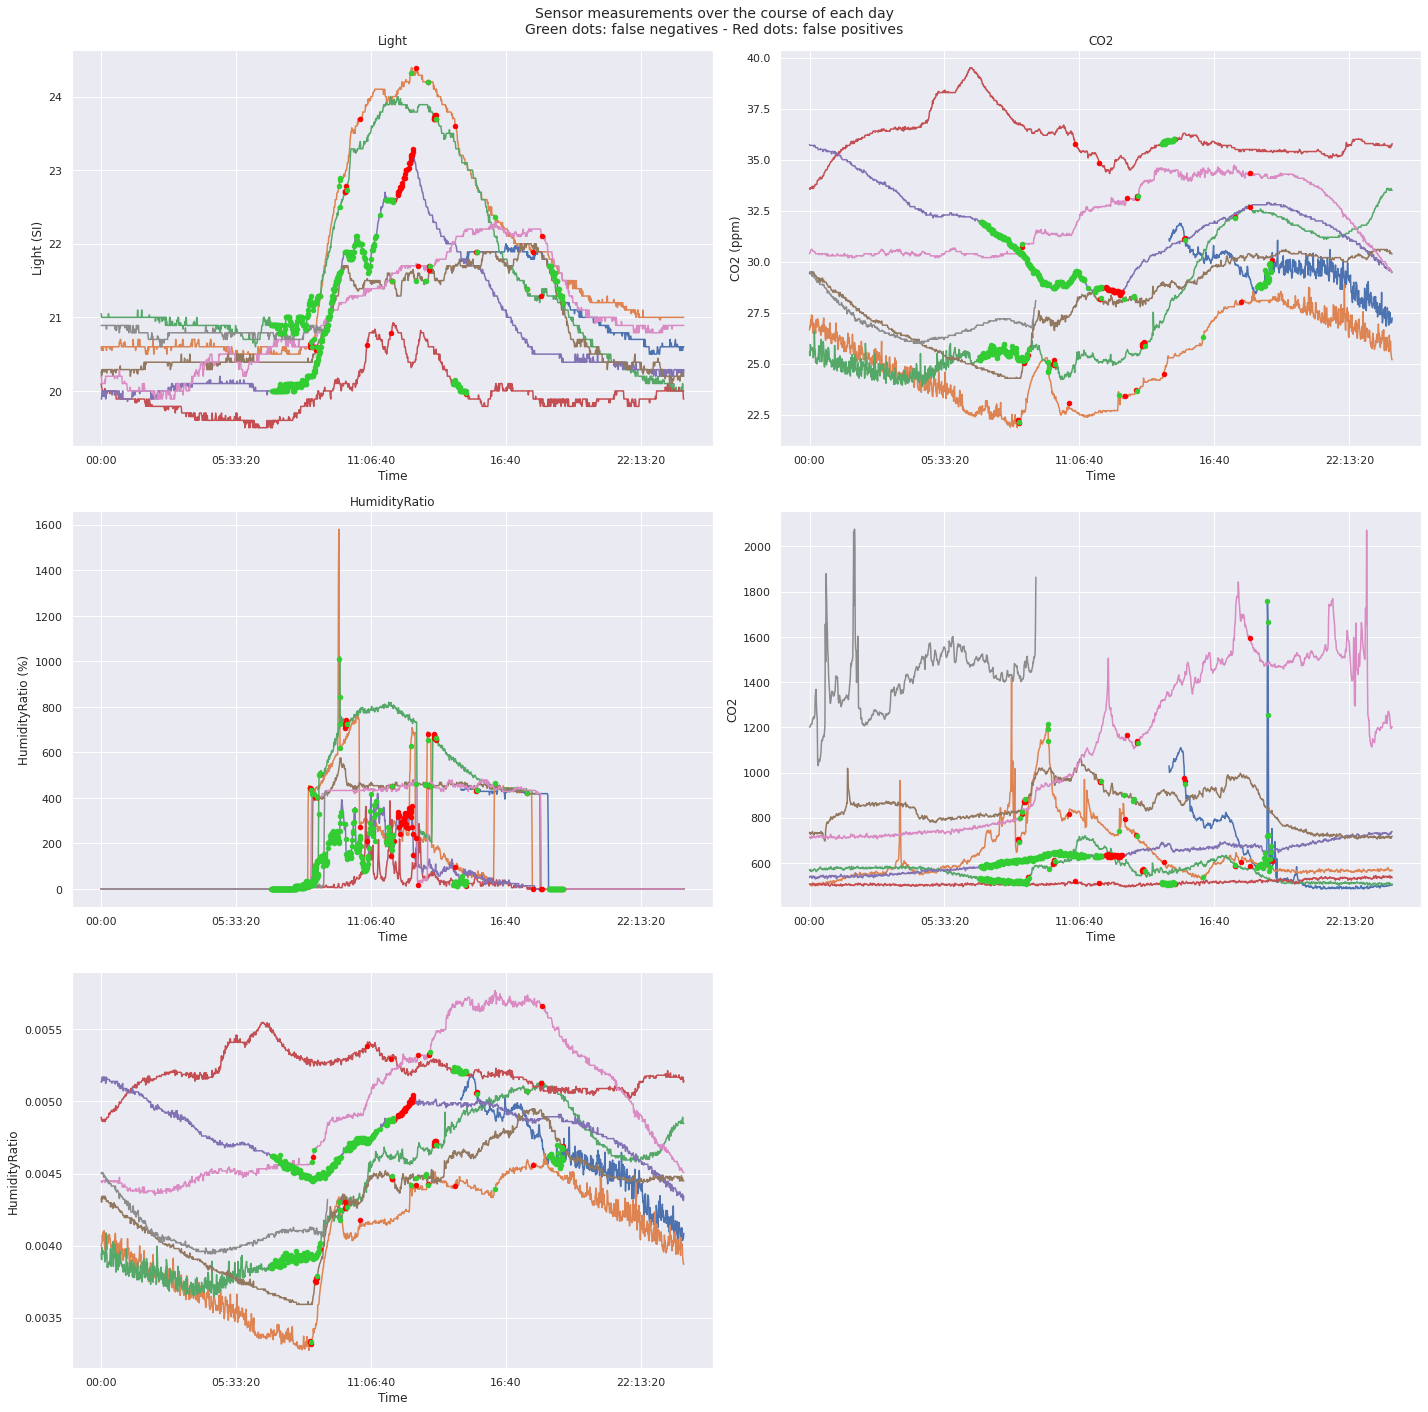

In [34]:
comparison = pd.DataFrame({"Target": test2_targets, "Predicted": predicted_classes2})
mistakes = comparison[comparison.Target != comparison.Predicted].index

full_test2_data, full_test2_targets, full_test2_targets_names = load_df("datasets/datatest2.xlsx")

error_targets = full_test2_targets.iloc[mistakes]
fneg_indices = error_targets[error_targets == 1].index
fpos_indices = error_targets[error_targets == 0].index


fnegs = full_test2_data.iloc[fneg_indices, :]
fposes = full_test2_data.iloc[fpos_indices, :]

plt.rcParams["figure.figsize"] = [20, 20]
fig, axs = plt.subplots(3, 2)

# Plot all data
for day in full_test2_data["Date"].unique():
    day_data = full_test2_data[full_test2_data["Date"] == day].set_index("Time")
    fneg_data = fnegs[fnegs["Date"] == day]
    fpos_data = fposes[fposes["Date"] == day]

    for i, col in enumerate(full_test2_data.columns[2:]):
        day_data[col].plot(ax=axs[i // 2, i % 2])
        fneg_data.plot.scatter(x="Time", y=col, ax=axs[i // 2, i % 2], color='limegreen', zorder=100)
        fpos_data.plot.scatter(x="Time", y=col, ax=axs[i // 2, i % 2], color='red', zorder=99)


units = {
    "Temperature": "°C",
    "Humidity": "%",
    "Light": "SI",
    "CO2": "ppm",
    "HumidityRatio": "%"
}
for i, col in enumerate(training_data.columns[2:]):
    axs[i // 2, i % 2].set_title(col)
    axs[i // 2, i % 2].set_ylabel(f"{col} ({units[col]})")
fig.suptitle("Sensor measurements over the course of each day\nGreen dots: false negatives - Red dots: false positives", fontsize=14)
axs[2, 1].axis('off')

plt.tight_layout()

On voit que les faux négatifs (points verts) correspondent à des moments où quelqu'un est dans la pièce mais que la lumière ainsi que le taux de CO2 sont faibles. Cela correspondrait donc à des situations où quelqu'un est dans la pièce, mais que les lumières sont éteintes et que la pièce est plutôt bien aérée.

## Partie 8: Impact de la variable luminosité

Les méthodes que nous avons mis en oeuvre finissent par accorder une très forte importance à la lumière dans la prise de décision. Cependant, cette variable peut intuitivement donner lieu à des problèmes puisqu'il est facile d'oublier d'éteindre ou d'allumer la lumière dans la pièce. Essayons donc de créer quelques modèles prédicitifs en excluant cette variable pour voir si on peut s'en passer:

In [35]:
# Load data suitable for LDA
training_data, training_targets, training_targets_names = load_df(
    "datasets/datatraining.xlsx", remove_timestamps=True
)
test_data, test_targets, test_targets_names = load_df(
    "datasets/datatest.xlsx", remove_timestamps=True
)
test2_data, test2_targets, test2_targets_names = load_df(
    "datasets/datatest2.xlsx", remove_timestamps=True
)

training_data.drop("Light", inplace=True, axis=1)
test_data.drop("Light", inplace=True, axis=1)
test2_data.drop("Light", inplace=True, axis=1)

# Fit data and train model
lda = LinearDiscriminantAnalysis()
lda.fit(training_data, training_targets)
transformed_test_data = lda.transform(test_data)

path shape: 8143 rows, 8 cols
path shape: 2665 rows, 8 cols
path shape: 9752 rows, 8 cols


Text(0, 0.5, 'Class')

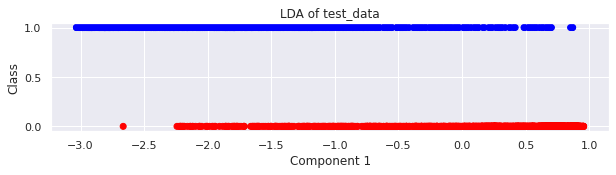

In [36]:
palette = ["red", "blue"]
colours = [palette[i] for i in test_targets]

plt.rcParams["figure.figsize"] = [10, 2]
plt.scatter(transformed_test_data, test_targets, c=colours)
plt.title("LDA of test_data")
plt.xlabel("Component 1")
plt.ylabel("Class")

Simplement en visualisant les données dans l'espace créé par l'ACP on peut se douter que ça ne va pas fonctionner très bien: il y a beaucoup trop de recouvrement entre nos deux classes. Essayons tout de même afin d'aboutir à une matrice de confusion:

Balanced accuracy for 'datatest.xlsx' (LDA): 0.8205561996990756
Balanced accuracy for 'datatest2.xlsx' (LDA): 0.5801024012534362
Balanced accuracy for 'datatest.xlsx' (LDA): 0.8205561996990756
Balanced accuracy for 'datatest2.xlsx' (LDA): 0.5801024012534362


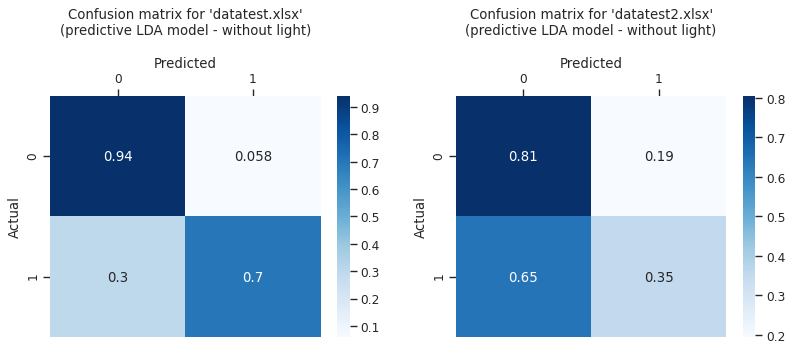

<Figure size 720x144 with 0 Axes>

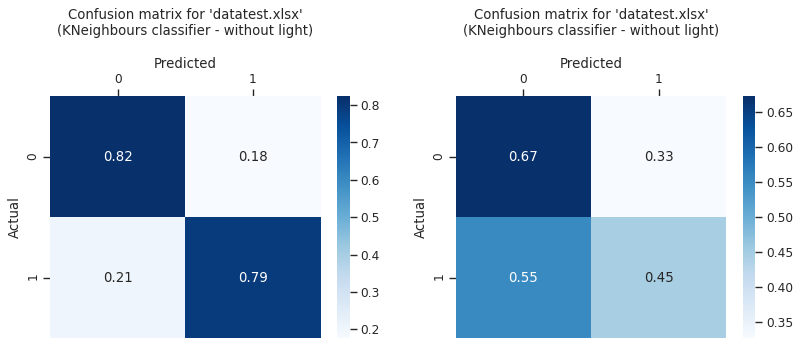

In [37]:
predicted_classes = lda.predict(test_data)

plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

cm_normalized = confusion_matrix(test_targets, predicted_classes, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'\n(predictive LDA model - without light)", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest.xlsx' (LDA): {balanced_accuracy_score(test_targets, predicted_classes)}")

transformed_test2_data = lda.transform(test2_data)
predicted_classes2 = lda.predict(test2_data)

ax = plt.subplot(1, 2, 2)
cm2_normalized = confusion_matrix(test2_targets, predicted_classes2, normalize="true")
sns.heatmap(cm2_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest2.xlsx'\n(predictive LDA model - without light)", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest2.xlsx' (LDA): {balanced_accuracy_score(test2_targets, predicted_classes2)}")

plt.figure()
k = 3
model = KNeighborsClassifier(n_neighbors=k)
model.fit(training_data, training_targets)


plt.figure(figsize=(12, 4), dpi=80)
ax = plt.subplot(1, 2, 1)

test_data_predicted = model.predict(test_data)

cm_normalized = confusion_matrix(test_targets, test_data_predicted, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'\n(KNeighbours classifier - without light)", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest.xlsx' (LDA): {balanced_accuracy_score(test_targets, predicted_classes)}")

test_data_predicted = model.predict(test_data)

ax = plt.subplot(1, 2, 2)

test2_data_predicted = model.predict(test2_data)

cm_normalized = confusion_matrix(test2_targets, test2_data_predicted, normalize="true")
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
plt.title(f"Confusion matrix for 'datatest.xlsx'\n(KNeighbours classifier - without light)", pad=20)
plt.ylabel(f"Actual")
plt.xlabel(f"Predicted")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.yaxis.tick_left()
print(f"Balanced accuracy for 'datatest2.xlsx' (LDA): {balanced_accuracy_score(test2_targets, predicted_classes2)}")

On voit que sans la lumière, les modèles ne sont pas précis du tout sur les deux jeux de données. Le seul cas qui garde une précision correcte sont les vrais négatifs: en moyenne il n'y a quelqu'un dans la pièce que de 8h à 17h, donc même prédire aléatoirement qu'il n'y a personne donnera plus de solutions vraies.

On ne peut donc pas se passer de la lumière afin d'obtenir des résultats corrects avec les autres capteurs à notre disposition.

## Conclusion

Nous avons donc testé différentes méthodes permettant de prédire la présence d'une personne dans la pièce. Nous avons vu dans un premier temps qu'une analyse discriminante linéaire permettait d'obtenir une bonne séparation de nos deux classes sur la base d'entraînement, mais que la performance du modèle prédictif est mitigé. En effet sur le premier jeu de données de test nous constatons une balanced accuracy de 98.3%, mais seulement 90,5% pour le deuxième avec 20% de faux négatifs. Nous avons ensuite utilisé trois autre méthodes: un classifieur binaire, un classifieur des K plus proches voisins et une analyse discriminante quadratique, mais ces méthodes nous ont toutes données des résultats comparables. Ensuite, nous avons proposé une hypothèse permettant de justifier ces résultats: la base de test 2 contiendrait des observations où une personne serait présente sans avoir allumé la lumière et en aérant la pièce. Si la base d'entrainement ne contient pas suffisamment de situations analogues, il est normal que nous ayons des résultats médiocres lorsque nos modèles font face à cette situation, d'autant plus que la luminosité est le facteur principal de prise de décision.  
Le choix d'utiliser la luminosité comme variable de décision paraît discutable: il est facile d'oublier d'éteindre une lumière, et la luminosité ambiante peut être très variable selon la période de l'année et la météo. Puisque cette étude a été réalisée uniquement pendant l'hiver, il est probable qu'arrivé l'été la luminosité plus forte en dehors des heures de travail fausse énormément les résultats.